## Install and Imports

In [ ]:
# (Re-)install Pytorch 2.2.1 (known to work). It might take a few minutes depending on network speed.
!pip uninstall --yes opencv-python opencv-python-headless opencv-contrib-python thinc
!pip uninstall --yes torch torchvision torchaudio torchtext
!pip install torch==2.2.1 torchvision==0.17.1

# Install scienceplot
!pip install scienceplots
!pip install scipy==1.16.0
!pip install torchsummary

# Install the Auto_LiRPA library.
!pip install git+https://github.com/Verified-Intelligence/auto_LiRPA

# Clear installation output to avoid clutter.
from IPython.display import clear_output
# clear_output()

Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-python-4.12.0.88
Found existing installation: opencv-python-headless 4.12.0.88
Uninstalling opencv-python-headless-4.12.0.88:
  Successfully uninstalled opencv-python-headless-4.12.0.88
Found existing installation: opencv-contrib-python 4.12.0.88
Uninstalling opencv-contrib-python-4.12.0.88:
  Successfully uninstalled opencv-contrib-python-4.12.0.88
Found existing installation: thinc 8.3.6
Uninstalling thinc-8.3.6:
  Successfully uninstalled thinc-8.3.6
Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
   ━━━━━━

In [ ]:
!pip install numpy==1.26.4

In [ ]:
import math
import joblib

import numpy as np
import h5py
import scipy
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import os

from auto_LiRPA import BoundedModule, BoundedTensor
from auto_LiRPA.perturbations import PerturbationLpNorm

from matplotlib import pyplot as plt
import matplotlib.patches as patches
from timeit import default_timer
import clust_augmentation as ca

from matplotlib.patches import Rectangle

# import scienceplots
# plt.style.use('science')

import warnings
warnings.filterwarnings("ignore")


## Load Data

In [ ]:
drive_path = 'drive/MyDrive/lirpa_darcy'
PATH = f'{drive_path}/Darcy_Triangular_FNO_int.mat'

In [ ]:
class MatReader(object):
    def __init__(self, file_path, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_float(self, to_float):
        self.to_float = to_float

In [ ]:
def create_data(path, n_train = 1000, n_val=500, n_test=200, rand = 42, ret="interval"):
    assert ret.lower() in ["interval", "midpoint"]

    reader = MatReader(path)

    r = 2
    h = int(((101 - 1)/r) + 1)
    s = h

    x_read_min = np.array(reader.read_field('boundCoeff_min')[:,::r,::r][:,:s,:s])
    x_read_max = np.array(reader.read_field('boundCoeff_max')[:,::r,::r][:,:s,:s])
    y_read_min = np.array(reader.read_field('sol_min')[:,::r,::r][:,:s,:s])
    y_read_max = np.array(reader.read_field('sol_max')[:,::r,::r][:,:s,:s])

    # Training data

    n_total = x_read_min.shape[0]
    n_test_all = n_total - n_train

    idxs = np.arange(x_read_min.shape[0])
    idx_train, idx_test = train_test_split(idxs, test_size=n_test_all/n_total,
                                            random_state=rand)
    idx_val, idx_test = train_test_split(idx_test, train_size=n_val/n_test_all,
                                            random_state=rand)

    x_min = x_read_min[:n_total].reshape((n_total, 1, s, s))  # X input
    x_max = x_read_max[:n_total].reshape((n_total, 1, s, s))  # X input
    y_min = y_read_min[:n_total].reshape((n_total, s, s, 1))  # HF output
    y_max = y_read_max[:n_total].reshape((n_total, s, s, 1))  # HF output

    idx_test = idx_test[:n_test, ...] # Get the actual number "n_test" test data

    u_train_min, g_train_min = x_min[idx_train, ...], y_min[idx_train, ...]
    u_train_max, g_train_max = x_max[idx_train, ...], y_max[idx_train, ...]
    u_val_min, g_val_min = x_min[idx_val, ...], y_min[idx_val, ...]
    u_val_max, g_val_max = x_max[idx_val, ...], y_max[idx_val, ...]
    u_test_min, g_test_min = x_min[idx_test, ...], y_min[idx_test, ...]
    u_test_max, g_test_max = x_max[idx_test, ...], y_max[idx_test, ...]

    # Get mid values for u_train, g_train, u_val, and g_val
    u_train_mid = 0.5 * (u_train_min + u_train_max)
    g_train_mid = 0.5 * (g_train_min + g_train_max)
    u_val_mid = 0.5 * (u_val_min + u_val_max)
    g_val_mid = 0.5 * (g_val_min + g_val_max)

    # x space
    n_train = u_train_min.shape[0]
    n_val = u_val_min.shape[0]
    n_test = u_test_min.shape[0]

    xspace = np.linspace(0,1,51,endpoint=False)
    yspace = xspace.copy()
    gridspace = np.meshgrid(xspace,xspace)
    x_grid = gridspace[0].reshape(51**2,1)
    y_grid = gridspace[1].reshape(51**2,1)

    x1_grid_train = np.tile(x_grid,(u_train_min.shape[0],1,1))
    x2_grid_train = np.tile(y_grid,(u_train_min.shape[0],1,1))
    x1_grid_test = np.tile(x_grid,(n_test,1,1))
    x2_grid_test = np.tile(y_grid,(n_test,1,1))

    space_train = np.concatenate([x2_grid_train,x1_grid_train], axis=-1)
    space_test = np.concatenate([x2_grid_test,x1_grid_test], axis=-1)

    # Stacking min and max
    u_train_int = np.stack([u_train_min, u_train_max], axis=-1)
    g_train_int = np.stack([g_train_min, g_train_max], axis=-1)

    u_test_int = np.stack([u_test_min, u_test_max], axis=-1)
    g_test_int = np.stack([g_test_min, g_test_max], axis=-1)

    u_val_int = np.stack([u_val_min, u_val_max], axis=-1)
    g_val_int = np.stack([g_val_min, g_val_max], axis=-1)

    if ret == "interval":
        return u_train_int, g_train_int, u_val_int, g_val_int, u_test_int, g_test_int, xspace, yspace
    else:
        return u_train_mid, g_train_mid, u_val_int, g_val_int, u_test_int, g_test_int, xspace, yspace

In [ ]:
u_train_mid, g_train_mid, u_val_int, g_val_int, u_test_int, g_test_int, xspace, yspace = create_data(PATH, n_train=1000, n_val=500,
                                                                                                     n_test=200, rand=42, ret="midpoint")

In [ ]:
u_train_mid.shape, g_train_mid.shape, u_test_int.shape, g_test_int.shape, u_val_int.shape, g_val_int.shape

((1000, 1, 51, 51),
 (1000, 51, 51, 1),
 (200, 1, 51, 51, 2),
 (200, 51, 51, 1, 2),
 (500, 1, 51, 51, 2),
 (500, 51, 51, 1, 2))

## Augmentation

In [ ]:
u_train_mid = u_train_mid.reshape(u_train_mid.shape[0], 51**2)
g_train_mid = g_train_mid.reshape(g_train_mid.shape[0], 51**2)
u_aug_train_0, g_aug_train_0, u_clust, g_clust = ca.construct_interval(u_train_mid, g_train_mid, n_clusters=[5,10,20,50,75,100,150,200,300])


100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


In [ ]:
u_aug_train = np.expand_dims(u_aug_train_0, axis=1).reshape(u_aug_train_0.shape[0], 1, 51, 51, 2)
g_aug_train = np.expand_dims(g_aug_train_0, axis=2).reshape(u_aug_train_0.shape[0], 51, 51, 1, 2)

In [ ]:
u_aug_train.shape, g_aug_train.shape

((801, 1, 51, 51, 2), (801, 51, 51, 1, 2))

## Formatter

In [ ]:
def data_formatter_nd_interval(u_data, g_data, sensor_coords, nsamp, eval_points=20):
    """
    Extended data formatter that supports upper/lower bounds in the last dimension.

    Parameters:
        u_data: ndarray, shape (nsamp, 1, ..., 2)
        g_data: ndarray, shape (nsamp, ..., 1, 2)
        sensor_coords: list of 1D arrays defining grid coordinates
        nsamp: number of samples to use
        eval_points: number of evaluation points per sample

    Returns:
        branch_tensor: (nsamp * eval_points, n_sensors_total, 2)
        trunk_tensor: (nsamp * eval_points, ndim)
        target_tensor: (nsamp * eval_points, 1, 2)
    """
    ndim = len(sensor_coords)
    sensor_grid = np.stack(np.meshgrid(*sensor_coords, indexing="ij"), axis=-1)  # (*sensor_shape, ndim)
    flat_coords = sensor_grid.reshape(-1, ndim)  # (n_sensors_total, ndim)
    n_sensors_total = flat_coords.shape[0]

    all_branch, all_trunk, all_target = [], [], []

    for i in range(nsamp):
        # Flatten both u and g but keep upper/lower as last dim
        u_i = u_data[i].reshape(-1, 2)  # (n_sensors_total, 2)
        g_i = g_data[i].reshape(-1, 2)  # (n_sensors_total, 2)

        # Random evaluation points
        indices = np.random.choice(n_sensors_total, size=eval_points, replace=False)

        for idx in indices:
            coord = flat_coords[idx]     # (ndim,)
            g_val = g_i[idx]             # (2,) — lower and upper values

            all_branch.append(u_i)       # entire input function with both bounds
            all_trunk.append(coord)
            all_target.append(g_val)     # both lower and upper bounds

    # Stack arrays into tensors
    branch_tensor = np.array(all_branch)   # (nsamp * eval_points, n_sensors_total, 2)
    trunk_tensor = np.array(all_trunk)     # (nsamp * eval_points, ndim)
    target_tensor = np.array(all_target)   # (nsamp * eval_points, 2)

    # Reshape target to (nsamp * eval_points, 1, 2)
    target_tensor = target_tensor.reshape(-1, 1, 2)

    return branch_tensor, trunk_tensor, target_tensor


In [ ]:
u_train, space_train, g_train = data_formatter_nd_interval(u_aug_train, g_aug_train, [xspace,yspace], nsamp=u_aug_train.shape[0], eval_points=200)
u_val, space_val, g_val = data_formatter_nd_interval(u_val_int, g_val_int, [xspace,yspace], nsamp=u_val_int.shape[0], eval_points=200)

In [ ]:
u_train.shape, space_train.shape, g_train.shape

((160200, 2601, 2), (160200, 2), (160200, 1, 2))

In [ ]:
u_val.shape, space_val.shape, g_val.shape

((100000, 2601, 2), (100000, 2), (100000, 1, 2))

## DeepONet Model

In [ ]:
# MLP builder
class MLP(nn.Module):
    def __init__(self, input_dim, output_features, hidden_features, num_hidden_layers):
        super(MLP, self).__init__()
        layers = []

        # Hidden layers
        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(input_dim, hidden_features))
            layers.append(nn.LeakyReLU())  # 'leaky_relu' activation
            input_dim = hidden_features

        # Output layer (linear activation)
        layers.append(nn.Linear(hidden_features, output_features))

        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

In [ ]:
# DeepONet architecture
class DeepONet(nn.Module):
    def __init__(self, y_in_size, u_in_size, trunk_params, branch_params, out_feat=1):
        """
        Args:
            y_in_size (tuple): e.g., (d_y,)
            u_in_size (tuple): e.g., (d_u,)
            trunk_params (dict): must include 'output_features', 'hidden_features', 'num_hidden_layers'
            branch_params (dict): same as above
            out_feat (int): number of output features
        """
        super(DeepONet, self).__init__()

        d_y = y_in_size[-1]
        d_u = u_in_size[-1]

        self.trunk = MLP(d_y, trunk_params["output_features"],
                         trunk_params["hidden_features"], trunk_params["num_hidden_layers"])

        self.branch = MLP(d_u, branch_params["output_features"],
                          branch_params["hidden_features"], branch_params["num_hidden_layers"])

        self.final = nn.Linear(trunk_params["output_features"], out_feat)

    def forward(self, y_input, u_input):
        # Each input is a batch of shape (batch_size, input_dim)
        trunk_out = self.trunk(y_input)    # (batch_size, output_features)
        branch_out = self.branch(u_input)  # (batch_size, output_features)

        # Elementwise multiply
        mult = trunk_out * branch_out

        # Final output
        return self.final(mult)

In [ ]:
trunk_params=dict()
trunk_params["output_features"] = 128
trunk_params["hidden_features"] = 128
trunk_params["num_hidden_layers"] = 2

branch_params=dict()
branch_params["output_features"] = 128
branch_params["hidden_features"] = 128
branch_params["num_hidden_layers"] = 1

In [ ]:
onet = DeepONet(y_in_size=(2,), u_in_size=(51**2,), trunk_params=trunk_params,
                branch_params=branch_params, out_feat=1)
summary(onet, [(2,), (51**2,)], device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             384
         LeakyReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
         LeakyReLU-4                  [-1, 128]               0
            Linear-5                  [-1, 128]          16,512
               MLP-6                  [-1, 128]               0
            Linear-7                  [-1, 128]         333,056
         LeakyReLU-8                  [-1, 128]               0
            Linear-9                  [-1, 128]          16,512
              MLP-10                  [-1, 128]               0
           Linear-11                    [-1, 1]             129
Total params: 383,105
Trainable params: 383,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/

In [ ]:
def mse_loss(pred, targets):
    """
    Computes the mse loss between predicted and actual.
    """
    loss = torch.mean(torch.square(pred - targets))

    return loss

In [ ]:
def interval_loss(pred_lo, pred_hi, targets):
    """
    Computes the interval loss between predicted lower and upper bounds.
    """
    term1 = torch.sqrt(F.mse_loss(pred_lo, targets[..., 0]))
    term2 = torch.sqrt(F.mse_loss(pred_hi, targets[..., 1]))
    loss = torch.mean(term1 + term2)

    return loss

In [ ]:
def train_deeponet(model,
                   train_loader,
                   loss_fun,
                   val_loader=None,
                   epochs=100,
                   optimizer=None,
                   device='cpu',
                   method='CROWN',
                   save_model=False,
                   save_dir='checkpoints',
                   save_best_only=True,
                   verbose=True):

    model.to(device)
    criterion = loss_fun

    best_val_loss = float('inf')
    best_train_loss = float('inf')
    best_state_dict = None

    train_losses = []
    val_losses = [] if val_loader is not None else None

    # lr_scheduler = MultiStepLR(optimizer, milestones=[500], gamma=0.5)

    # Wrap LiRPA model
    lirpa_model = BoundedModule(model, (torch.empty((1,2)), torch.empty((1,51**2))), device=device)

    if save_model:
        os.makedirs(save_dir, exist_ok=True)

    # training loop
    for epoch in range(epochs):

        t0 = default_timer()
        model.train()
        train_loss = 0.0

        for y_batch, u_batch, target in train_loader:
            y_batch = y_batch.to(device)
            u_batch = u_batch.to(device)
            target = target.to(device)

            # Convert u inputs to interval
            ub_in = u_batch[..., 1]
            lb_in = u_batch[..., 0]

            center = (lb_in + ub_in) / 2
            eps = (ub_in - lb_in) / 2

            # Define perturbation with per-feature epsilon
            perturbation = PerturbationLpNorm(norm=float("inf"), eps=eps)

            # Wrap input as a bounded tensor
            u_bounded = BoundedTensor(center, perturbation)

            optimizer.zero_grad()
            lb_pred,ub_pred = lirpa_model.compute_bounds(x=(y_batch, u_bounded), method=method)

            loss = criterion(lb_pred, ub_pred, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * y_batch.size(0)

        # lr_scheduler.step()
        train_loss /= len(train_loader.dataset)
        t1 = default_timer() - t0
        train_losses.append(train_loss)

        log_msg = f"[Epoch {epoch+1}/{epochs}] Train RMSE: {train_loss:.4f} | Time: {t1:.4f}s"

        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for y_val, u_val, target_val in val_loader:
                    y_val = y_val.to(device)
                    u_val = u_val.to(device)
                    target_val = target_val.to(device)

                    # Convert u inputs to interval
                    ub_val = u_val[..., 1]
                    lb_val = u_val[..., 0]

                    center_val = (lb_val + ub_val) / 2
                    eps_val = (ub_val - lb_val) / 2

                    # Define perturbation with per-feature epsilon
                    perturbation_val = PerturbationLpNorm(norm=float("inf"), eps=eps_val)

                    # Wrap input as a bounded tensor
                    u_bounded_val = BoundedTensor(center_val, perturbation_val)

                    lb_pred_val, ub_pred_val = lirpa_model.compute_bounds(x=(y_val, u_bounded_val), method=method)
                    loss = criterion(lb_pred_val, ub_pred_val, target_val)
                    val_loss += loss.item() * y_val.size(0)

            val_loss /= len(val_loader.dataset)
            val_losses.append(val_loss)

            log_msg += f" | Val RMSE: {val_loss:.4f}"

            # Track best model (by val_loss)
            if epoch > 50 and val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state_dict = model.state_dict()
                print(f"Best model updated at epoch {epoch+1} with loss {best_val_loss:.4f}")

        else:
             # No validation set: use train_loss as criterion
            if epoch > 50 and train_loss < best_train_loss:
                best_train_loss = train_loss
                best_state_dict = model.state_dict()
                print(f"Best model updated at epoch {epoch+1} with loss {best_train_loss:.4f}")

        if verbose:
            print(log_msg)

    # Reload best weights before returning
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

        # Save only once at the end
        if save_model:
            fname = "best_model.pt" if save_best_only else "last_model.pt"
            model_path = os.path.join(save_dir, fname)
            torch.save(best_state_dict, model_path)
            print(f"Best model saved to {model_path}")

    return lirpa_model, train_losses, val_losses

In [ ]:
def run_experiments(trunk_params, branch_params, bound="CROWN", n_train=750, repetitions=5, epochs=100, batch= 1024, verbose=0):

    drive_path = 'drive/MyDrive/lirpa_darcy'
    PATH = f'{drive_path}/Darcy_Triangular_FNO_int.mat'

    n_val = 200
    n_test = 200

    dev = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using {dev} device")
    results = []
    for seed in tqdm(range(repetitions)):
        print(f"Experiment {seed+1}/{repetitions}")
        # Get data
        u_train_mid, g_train_mid, u_val_int, g_val_int, u_test_int, g_test_int, xspace, yspace = create_data(PATH, n_train=1000, n_val=n_val,
                                                                                                             n_test=n_test, rand=42, ret="midpoint")
        # Augment data
        u_train_mid = u_train_mid.reshape(u_train_mid.shape[0], 51**2)
        g_train_mid = g_train_mid.reshape(g_train_mid.shape[0], 51**2)
        u_aug_train_0, g_aug_train_0, u_clust, g_clust = ca.construct_interval(u_train_mid, g_train_mid, n_clusters=[5,10,20,50,75,100,150,200,300])

        u_aug_train = np.expand_dims(u_aug_train_0, axis=1).reshape(u_aug_train_0.shape[0], 1, 51, 51, 2)
        g_aug_train = np.expand_dims(g_aug_train_0, axis=2).reshape(u_aug_train_0.shape[0], 51, 51, 1, 2)
        # get random index with random seed
        np.random.seed(seed)
        idx = np.random.choice(u_aug_train.shape[0], size=n_train, replace=False)
        u_train_int = u_aug_train[idx,...]
        g_train_int = g_aug_train[idx,...]

        # Transform data shape
        u_train, space_train, g_train = data_formatter_nd_interval(u_train_int, g_train_int, [xspace,yspace], nsamp=u_train_int.shape[0], eval_points=200)
        u_val, space_val, g_val = data_formatter_nd_interval(u_val_int, g_val_int, [xspace,yspace], nsamp=u_val_int.shape[0], eval_points=100)

        # Define model
        model = DeepONet(y_in_size=(2,), u_in_size=(51**2,), trunk_params=trunk_params,
                        branch_params=branch_params, out_feat=1)

        # Set optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        res = dict()

        # Create data loader
        train_dataset = TensorDataset(torch.tensor(space_train, dtype=torch.float32),
                              torch.tensor(u_train, dtype=torch.float32),
                              torch.tensor(g_train, dtype=torch.float32))
        train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

        val_dataset = TensorDataset(torch.tensor(space_val, dtype=torch.float32),
                                    torch.tensor(u_val, dtype=torch.float32),
                                    torch.tensor(g_val, dtype=torch.float32))
        val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

        # Train model
        model, train_losses, val_losses = train_deeponet(model,
                                                    train_loader,
                                                    loss_fun=interval_loss,
                                                    val_loader=val_loader,
                                                    optimizer=optimizer,
                                                    epochs=epochs,
                                                    device=dev,
                                                    method=bound,
                                                    save_model=True,
                                                    save_dir='ideal_crown/',
                                                    save_best_only=True,
                                                    verbose=verbose)

        ### Evaluate on test set ###
        # Make grid
        gridspace = np.meshgrid(xspace,xspace)
        x_grid = gridspace[0].reshape(51**2)
        y_grid = gridspace[1].reshape(51**2)
        sensor_data = torch.Tensor(np.stack([x_grid,y_grid],axis=0).T).to('cuda')

        lb_pred_list = []
        ub_pred_list = []
        u_test_flat = u_test_int.reshape(n_test, 51**2, 2)
        model.eval()
        for i in range(n_test):
            u_test_lo = u_test_flat[...,0]
            u_test_up = u_test_flat[...,1]
            u_lo = torch.Tensor(u_test_lo[i][None,:].repeat(2601,0)).to('cuda')
            u_up = torch.Tensor(u_test_up[i][None,:].repeat(2601,0)).to('cuda')

            center_test = (u_lo + u_up) / 2
            eps_test = (u_up - u_lo) / 2

            # Define perturbation with per-feature epsilon
            perturbation_test = PerturbationLpNorm(norm=float("inf"), eps=eps_test)

            # Wrap input as a bounded tensor
            u_bounded_test = BoundedTensor(center_test, perturbation_test)

            lb_pred_test, ub_pred_test = model.compute_bounds(x=(sensor_data, u_bounded_test), method=bound)
            lb_pred_list.append(lb_pred_test.detach().cpu().numpy())
            ub_pred_list.append(ub_pred_test.detach().cpu().numpy())

        lb_pred = np.concatenate(lb_pred_list, axis=0).reshape(n_test,51,51).swapaxes(1, 2)
        ub_pred = np.concatenate(ub_pred_list, axis=0).reshape(n_test,51,51).swapaxes(1, 2)

        res["u_train"] = u_train_int
        res["y_train"] = xspace
        res["g_train"] = g_train_int
        res["u_test"] = u_test_int
        res["y_test"] = sensor_data
        res["g_test"] = g_test_int
        res["lb_pred"] = lb_pred
        res["ub_pred"] = ub_pred
        res["train_losses"] = train_losses
        res["val_losses"] = val_losses

        results.append(res)

    return results


In [22]:
for nt in [750,500,250,150]:
    print(f"### PROCESSING N_TRAIN {nt} ###")
    results = run_experiments(trunk_params, branch_params, bound="CROWN",
                            n_train=nt, repetitions=10, epochs=150, batch= 1024, verbose=0)
    joblib.dump(results, f"{drive_path}/deeponet2d_augmented_crown_ntrain{nt}.pkl")

### PROCESSING N_TRAIN 750 ###
Using cuda device


  0%|          | 0/10 [00:00<?, ?it/s]

Experiment 1/10



100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


Best model updated at epoch 52 with loss 0.1859
Best model updated at epoch 53 with loss 0.1728
Best model updated at epoch 54 with loss 0.1716
Best model updated at epoch 62 with loss 0.1710
Best model updated at epoch 63 with loss 0.1624
Best model updated at epoch 65 with loss 0.1614
Best model updated at epoch 68 with loss 0.1607
Best model updated at epoch 70 with loss 0.1583
Best model updated at epoch 75 with loss 0.1562
Best model updated at epoch 78 with loss 0.1516
Best model updated at epoch 81 with loss 0.1498
Best model updated at epoch 96 with loss 0.1449
Best model updated at epoch 109 with loss 0.1410
Best model updated at epoch 130 with loss 0.1404
Best model updated at epoch 133 with loss 0.1367
Best model updated at epoch 139 with loss 0.1340
Best model saved to ideal_crown/best_model.pt


 10%|█         | 1/10 [12:23<1:51:32, 743.57s/it]

Experiment 2/10



100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


Best model updated at epoch 52 with loss 0.1676
Best model updated at epoch 54 with loss 0.1638
Best model updated at epoch 58 with loss 0.1604
Best model updated at epoch 68 with loss 0.1553
Best model updated at epoch 77 with loss 0.1512
Best model updated at epoch 79 with loss 0.1497
Best model updated at epoch 83 with loss 0.1484
Best model updated at epoch 90 with loss 0.1473
Best model updated at epoch 101 with loss 0.1449
Best model updated at epoch 106 with loss 0.1435
Best model updated at epoch 115 with loss 0.1429
Best model updated at epoch 124 with loss 0.1365
Best model updated at epoch 129 with loss 0.1351
Best model saved to ideal_crown/best_model.pt


 20%|██        | 2/10 [23:58<1:35:17, 714.69s/it]

Experiment 3/10



100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Best model updated at epoch 52 with loss 0.1724
Best model updated at epoch 56 with loss 0.1599
Best model updated at epoch 69 with loss 0.1541
Best model updated at epoch 71 with loss 0.1531
Best model updated at epoch 74 with loss 0.1528
Best model updated at epoch 76 with loss 0.1509
Best model updated at epoch 93 with loss 0.1493
Best model updated at epoch 94 with loss 0.1481
Best model updated at epoch 95 with loss 0.1464
Best model updated at epoch 96 with loss 0.1445
Best model updated at epoch 106 with loss 0.1428
Best model updated at epoch 118 with loss 0.1409
Best model updated at epoch 126 with loss 0.1401
Best model updated at epoch 130 with loss 0.1401
Best model updated at epoch 139 with loss 0.1391
Best model saved to ideal_crown/best_model.pt


 30%|███       | 3/10 [35:24<1:21:52, 701.82s/it]

Experiment 4/10



100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Best model updated at epoch 52 with loss 0.1849
Best model updated at epoch 53 with loss 0.1708
Best model updated at epoch 57 with loss 0.1686
Best model updated at epoch 61 with loss 0.1643
Best model updated at epoch 65 with loss 0.1640
Best model updated at epoch 67 with loss 0.1582
Best model updated at epoch 72 with loss 0.1577
Best model updated at epoch 74 with loss 0.1574
Best model updated at epoch 75 with loss 0.1558
Best model updated at epoch 77 with loss 0.1507
Best model updated at epoch 78 with loss 0.1442
Best model updated at epoch 97 with loss 0.1420
Best model updated at epoch 106 with loss 0.1405
Best model updated at epoch 124 with loss 0.1382
Best model updated at epoch 132 with loss 0.1381
Best model updated at epoch 135 with loss 0.1342
Best model saved to ideal_crown/best_model.pt


 40%|████      | 4/10 [47:15<1:10:32, 705.50s/it]

Experiment 5/10



100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


Best model updated at epoch 52 with loss 0.1785
Best model updated at epoch 55 with loss 0.1633
Best model updated at epoch 59 with loss 0.1623
Best model updated at epoch 63 with loss 0.1588
Best model updated at epoch 72 with loss 0.1561
Best model updated at epoch 75 with loss 0.1540
Best model updated at epoch 94 with loss 0.1537
Best model updated at epoch 96 with loss 0.1529
Best model updated at epoch 104 with loss 0.1419
Best model updated at epoch 136 with loss 0.1418
Best model updated at epoch 144 with loss 0.1394
Best model updated at epoch 147 with loss 0.1384
Best model saved to ideal_crown/best_model.pt


 50%|█████     | 5/10 [59:09<59:02, 708.57s/it]  

Experiment 6/10



100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Best model updated at epoch 52 with loss 0.1912
Best model updated at epoch 53 with loss 0.1715
Best model updated at epoch 58 with loss 0.1652
Best model updated at epoch 73 with loss 0.1628
Best model updated at epoch 74 with loss 0.1622
Best model updated at epoch 75 with loss 0.1614
Best model updated at epoch 77 with loss 0.1505
Best model updated at epoch 88 with loss 0.1491
Best model updated at epoch 91 with loss 0.1445
Best model updated at epoch 95 with loss 0.1443
Best model updated at epoch 106 with loss 0.1414
Best model updated at epoch 117 with loss 0.1378
Best model updated at epoch 130 with loss 0.1373
Best model saved to ideal_crown/best_model.pt


 60%|██████    | 6/10 [1:10:48<47:00, 705.15s/it]

Experiment 7/10



100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


Best model updated at epoch 52 with loss 0.1694
Best model updated at epoch 53 with loss 0.1655
Best model updated at epoch 54 with loss 0.1638
Best model updated at epoch 59 with loss 0.1539
Best model updated at epoch 64 with loss 0.1516
Best model updated at epoch 77 with loss 0.1505
Best model updated at epoch 86 with loss 0.1503
Best model updated at epoch 89 with loss 0.1502
Best model updated at epoch 92 with loss 0.1440
Best model updated at epoch 96 with loss 0.1403
Best model updated at epoch 111 with loss 0.1364
Best model updated at epoch 126 with loss 0.1321
Best model updated at epoch 143 with loss 0.1321
Best model updated at epoch 144 with loss 0.1293
Best model saved to ideal_crown/best_model.pt


 70%|███████   | 7/10 [1:22:52<35:33, 711.27s/it]

Experiment 8/10



100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


Best model updated at epoch 52 with loss 0.1660
Best model updated at epoch 56 with loss 0.1631
Best model updated at epoch 61 with loss 0.1582
Best model updated at epoch 71 with loss 0.1532
Best model updated at epoch 78 with loss 0.1467
Best model updated at epoch 83 with loss 0.1394
Best model updated at epoch 119 with loss 0.1360
Best model updated at epoch 135 with loss 0.1334
Best model saved to ideal_crown/best_model.pt


 80%|████████  | 8/10 [1:35:02<23:54, 717.26s/it]

Experiment 9/10



100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


Best model updated at epoch 52 with loss 0.1767
Best model updated at epoch 54 with loss 0.1634
Best model updated at epoch 56 with loss 0.1609
Best model updated at epoch 59 with loss 0.1542
Best model updated at epoch 83 with loss 0.1505
Best model updated at epoch 93 with loss 0.1497
Best model updated at epoch 94 with loss 0.1487
Best model updated at epoch 95 with loss 0.1458
Best model updated at epoch 97 with loss 0.1426
Best model updated at epoch 103 with loss 0.1407
Best model updated at epoch 126 with loss 0.1389
Best model updated at epoch 140 with loss 0.1362
Best model updated at epoch 148 with loss 0.1359
Best model saved to ideal_crown/best_model.pt


 90%|█████████ | 9/10 [1:46:59<11:57, 717.36s/it]

Experiment 10/10



100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


Best model updated at epoch 52 with loss 0.1716
Best model updated at epoch 54 with loss 0.1669
Best model updated at epoch 55 with loss 0.1640
Best model updated at epoch 61 with loss 0.1572
Best model updated at epoch 72 with loss 0.1550
Best model updated at epoch 73 with loss 0.1517
Best model updated at epoch 77 with loss 0.1485
Best model updated at epoch 83 with loss 0.1422
Best model updated at epoch 109 with loss 0.1403
Best model updated at epoch 111 with loss 0.1396
Best model updated at epoch 118 with loss 0.1375
Best model updated at epoch 120 with loss 0.1366
Best model updated at epoch 132 with loss 0.1323
Best model saved to ideal_crown/best_model.pt


100%|██████████| 10/10 [1:59:06<00:00, 714.66s/it]


### PROCESSING N_TRAIN 500 ###
Using cuda device


  0%|          | 0/10 [00:00<?, ?it/s]

Experiment 1/10



100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


Best model updated at epoch 52 with loss 0.1950
Best model updated at epoch 57 with loss 0.1878
Best model updated at epoch 60 with loss 0.1788
Best model updated at epoch 61 with loss 0.1781
Best model updated at epoch 70 with loss 0.1749
Best model updated at epoch 71 with loss 0.1684
Best model updated at epoch 79 with loss 0.1558
Best model updated at epoch 98 with loss 0.1507
Best model updated at epoch 127 with loss 0.1465
Best model updated at epoch 142 with loss 0.1439
Best model updated at epoch 150 with loss 0.1438
Best model saved to ideal_crown/best_model.pt


 10%|█         | 1/10 [08:19<1:14:58, 499.81s/it]

Experiment 2/10



100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


Best model updated at epoch 52 with loss 0.2008
Best model updated at epoch 57 with loss 0.1839
Best model updated at epoch 68 with loss 0.1826
Best model updated at epoch 70 with loss 0.1722
Best model updated at epoch 77 with loss 0.1711
Best model updated at epoch 79 with loss 0.1703
Best model updated at epoch 86 with loss 0.1699
Best model updated at epoch 87 with loss 0.1684
Best model updated at epoch 92 with loss 0.1629
Best model updated at epoch 98 with loss 0.1628
Best model updated at epoch 105 with loss 0.1596
Best model updated at epoch 119 with loss 0.1546
Best model updated at epoch 121 with loss 0.1541
Best model updated at epoch 128 with loss 0.1538
Best model updated at epoch 134 with loss 0.1503
Best model saved to ideal_crown/best_model.pt


 20%|██        | 2/10 [16:29<1:05:51, 494.00s/it]

Experiment 3/10



100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


Best model updated at epoch 52 with loss 0.2059
Best model updated at epoch 53 with loss 0.2055
Best model updated at epoch 54 with loss 0.1963
Best model updated at epoch 59 with loss 0.1904
Best model updated at epoch 64 with loss 0.1881
Best model updated at epoch 66 with loss 0.1818
Best model updated at epoch 67 with loss 0.1746
Best model updated at epoch 72 with loss 0.1709
Best model updated at epoch 74 with loss 0.1610
Best model updated at epoch 89 with loss 0.1564
Best model updated at epoch 94 with loss 0.1563
Best model updated at epoch 102 with loss 0.1516
Best model updated at epoch 115 with loss 0.1497
Best model updated at epoch 129 with loss 0.1475
Best model updated at epoch 133 with loss 0.1474
Best model updated at epoch 135 with loss 0.1457
Best model updated at epoch 143 with loss 0.1441
Best model updated at epoch 145 with loss 0.1413
Best model saved to ideal_crown/best_model.pt


 30%|███       | 3/10 [24:39<57:24, 492.01s/it]  

Experiment 4/10



100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Best model updated at epoch 52 with loss 0.2137
Best model updated at epoch 53 with loss 0.2110
Best model updated at epoch 56 with loss 0.2093
Best model updated at epoch 57 with loss 0.2053
Best model updated at epoch 60 with loss 0.2028
Best model updated at epoch 63 with loss 0.1951
Best model updated at epoch 68 with loss 0.1923
Best model updated at epoch 69 with loss 0.1865
Best model updated at epoch 73 with loss 0.1739
Best model updated at epoch 79 with loss 0.1731
Best model updated at epoch 87 with loss 0.1712
Best model updated at epoch 89 with loss 0.1705
Best model updated at epoch 90 with loss 0.1676
Best model updated at epoch 92 with loss 0.1669
Best model updated at epoch 96 with loss 0.1663
Best model updated at epoch 97 with loss 0.1663
Best model updated at epoch 98 with loss 0.1558
Best model updated at epoch 122 with loss 0.1525
Best model updated at epoch 132 with loss 0.1518
Best model updated at epoch 141 with loss 0.1511
Best model updated at epoch 147 with 

 40%|████      | 4/10 [32:45<48:57, 489.65s/it]

Experiment 5/10



100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


Best model updated at epoch 52 with loss 0.2118
Best model updated at epoch 54 with loss 0.1948
Best model updated at epoch 59 with loss 0.1931
Best model updated at epoch 60 with loss 0.1911
Best model updated at epoch 63 with loss 0.1813
Best model updated at epoch 69 with loss 0.1801
Best model updated at epoch 70 with loss 0.1776
Best model updated at epoch 72 with loss 0.1747
Best model updated at epoch 83 with loss 0.1654
Best model updated at epoch 86 with loss 0.1625
Best model updated at epoch 94 with loss 0.1580
Best model updated at epoch 106 with loss 0.1544
Best model updated at epoch 108 with loss 0.1533
Best model updated at epoch 110 with loss 0.1516
Best model updated at epoch 127 with loss 0.1501
Best model updated at epoch 134 with loss 0.1493
Best model updated at epoch 137 with loss 0.1479
Best model saved to ideal_crown/best_model.pt


 50%|█████     | 5/10 [41:09<41:13, 494.76s/it]

Experiment 6/10



100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


Best model updated at epoch 52 with loss 0.1931
Best model updated at epoch 53 with loss 0.1824
Best model updated at epoch 54 with loss 0.1779
Best model updated at epoch 61 with loss 0.1748
Best model updated at epoch 73 with loss 0.1689
Best model updated at epoch 74 with loss 0.1644
Best model updated at epoch 77 with loss 0.1570
Best model updated at epoch 84 with loss 0.1553
Best model updated at epoch 95 with loss 0.1540
Best model updated at epoch 99 with loss 0.1527
Best model updated at epoch 101 with loss 0.1526
Best model updated at epoch 103 with loss 0.1514
Best model updated at epoch 105 with loss 0.1501
Best model updated at epoch 117 with loss 0.1499
Best model updated at epoch 119 with loss 0.1470
Best model updated at epoch 121 with loss 0.1463
Best model updated at epoch 123 with loss 0.1443
Best model updated at epoch 126 with loss 0.1427
Best model updated at epoch 141 with loss 0.1371
Best model saved to ideal_crown/best_model.pt


 60%|██████    | 6/10 [49:31<33:09, 497.37s/it]

Experiment 7/10



100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


Best model updated at epoch 52 with loss 0.2243
Best model updated at epoch 53 with loss 0.2059
Best model updated at epoch 56 with loss 0.2015
Best model updated at epoch 58 with loss 0.2013
Best model updated at epoch 59 with loss 0.1967
Best model updated at epoch 64 with loss 0.1950
Best model updated at epoch 67 with loss 0.1791
Best model updated at epoch 68 with loss 0.1773
Best model updated at epoch 75 with loss 0.1672
Best model updated at epoch 78 with loss 0.1664
Best model updated at epoch 83 with loss 0.1628
Best model updated at epoch 88 with loss 0.1617
Best model updated at epoch 92 with loss 0.1605
Best model updated at epoch 103 with loss 0.1554
Best model updated at epoch 125 with loss 0.1548
Best model updated at epoch 126 with loss 0.1539
Best model updated at epoch 127 with loss 0.1470
Best model saved to ideal_crown/best_model.pt


 70%|███████   | 7/10 [57:39<24:42, 494.22s/it]

Experiment 8/10



100%|██████████| 9/9 [00:07<00:00,  1.29it/s]


Best model updated at epoch 52 with loss 0.2115
Best model updated at epoch 53 with loss 0.1963
Best model updated at epoch 54 with loss 0.1906
Best model updated at epoch 56 with loss 0.1872
Best model updated at epoch 60 with loss 0.1821
Best model updated at epoch 61 with loss 0.1756
Best model updated at epoch 65 with loss 0.1755
Best model updated at epoch 67 with loss 0.1746
Best model updated at epoch 72 with loss 0.1726
Best model updated at epoch 73 with loss 0.1719
Best model updated at epoch 75 with loss 0.1701
Best model updated at epoch 76 with loss 0.1693
Best model updated at epoch 80 with loss 0.1675
Best model updated at epoch 83 with loss 0.1659
Best model updated at epoch 91 with loss 0.1643
Best model updated at epoch 94 with loss 0.1531
Best model updated at epoch 103 with loss 0.1488
Best model updated at epoch 139 with loss 0.1465
Best model updated at epoch 143 with loss 0.1458
Best model saved to ideal_crown/best_model.pt


 80%|████████  | 8/10 [1:05:46<16:24, 492.09s/it]

Experiment 9/10



100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Best model updated at epoch 52 with loss 0.2366
Best model updated at epoch 53 with loss 0.2173
Best model updated at epoch 54 with loss 0.2024
Best model updated at epoch 55 with loss 0.1977
Best model updated at epoch 61 with loss 0.1862
Best model updated at epoch 68 with loss 0.1776
Best model updated at epoch 76 with loss 0.1765
Best model updated at epoch 78 with loss 0.1686
Best model updated at epoch 80 with loss 0.1670
Best model updated at epoch 82 with loss 0.1601
Best model updated at epoch 105 with loss 0.1543
Best model updated at epoch 109 with loss 0.1518
Best model updated at epoch 115 with loss 0.1485
Best model updated at epoch 121 with loss 0.1451
Best model updated at epoch 150 with loss 0.1426
Best model saved to ideal_crown/best_model.pt


 90%|█████████ | 9/10 [1:13:53<08:10, 490.24s/it]

Experiment 10/10



100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


Best model updated at epoch 52 with loss 0.2122
Best model updated at epoch 54 with loss 0.2059
Best model updated at epoch 57 with loss 0.2019
Best model updated at epoch 58 with loss 0.1895
Best model updated at epoch 61 with loss 0.1872
Best model updated at epoch 62 with loss 0.1771
Best model updated at epoch 69 with loss 0.1744
Best model updated at epoch 70 with loss 0.1729
Best model updated at epoch 75 with loss 0.1722
Best model updated at epoch 78 with loss 0.1704
Best model updated at epoch 83 with loss 0.1665
Best model updated at epoch 89 with loss 0.1615
Best model updated at epoch 94 with loss 0.1563
Best model updated at epoch 106 with loss 0.1543
Best model updated at epoch 110 with loss 0.1535
Best model updated at epoch 113 with loss 0.1521
Best model updated at epoch 131 with loss 0.1509
Best model updated at epoch 133 with loss 0.1480
Best model updated at epoch 150 with loss 0.1437
Best model saved to ideal_crown/best_model.pt


100%|██████████| 10/10 [1:22:16<00:00, 493.64s/it]


### PROCESSING N_TRAIN 250 ###
Using cuda device


  0%|          | 0/10 [00:00<?, ?it/s]

Experiment 1/10



100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Best model updated at epoch 52 with loss 0.2305
Best model updated at epoch 54 with loss 0.2259
Best model updated at epoch 55 with loss 0.2243
Best model updated at epoch 58 with loss 0.2203
Best model updated at epoch 65 with loss 0.2189
Best model updated at epoch 83 with loss 0.2179
Best model updated at epoch 89 with loss 0.2176
Best model updated at epoch 93 with loss 0.2143
Best model updated at epoch 101 with loss 0.2122
Best model updated at epoch 104 with loss 0.2050
Best model updated at epoch 107 with loss 0.2041
Best model updated at epoch 113 with loss 0.2011
Best model updated at epoch 116 with loss 0.1945
Best model updated at epoch 117 with loss 0.1924
Best model updated at epoch 120 with loss 0.1864
Best model updated at epoch 123 with loss 0.1855
Best model updated at epoch 137 with loss 0.1836
Best model updated at epoch 140 with loss 0.1810
Best model updated at epoch 146 with loss 0.1772
Best model updated at epoch 149 with loss 0.1687
Best model saved to ideal_cr

 10%|█         | 1/10 [04:57<44:33, 297.06s/it]

Experiment 2/10



100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Best model updated at epoch 52 with loss 0.2141
Best model updated at epoch 86 with loss 0.2094
Best model updated at epoch 89 with loss 0.2035
Best model updated at epoch 96 with loss 0.2005
Best model updated at epoch 104 with loss 0.2000
Best model updated at epoch 106 with loss 0.1986
Best model updated at epoch 107 with loss 0.1919
Best model updated at epoch 108 with loss 0.1877
Best model updated at epoch 109 with loss 0.1863
Best model updated at epoch 114 with loss 0.1724
Best model updated at epoch 135 with loss 0.1672
Best model updated at epoch 149 with loss 0.1644
Best model saved to ideal_crown/best_model.pt


 20%|██        | 2/10 [09:55<39:43, 297.91s/it]

Experiment 3/10



100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Best model updated at epoch 52 with loss 0.2118
Best model updated at epoch 56 with loss 0.2084
Best model updated at epoch 87 with loss 0.2075
Best model updated at epoch 93 with loss 0.2029
Best model updated at epoch 100 with loss 0.1950
Best model updated at epoch 110 with loss 0.1905
Best model updated at epoch 115 with loss 0.1884
Best model updated at epoch 119 with loss 0.1846
Best model updated at epoch 120 with loss 0.1845
Best model updated at epoch 133 with loss 0.1781
Best model updated at epoch 146 with loss 0.1735
Best model saved to ideal_crown/best_model.pt


 30%|███       | 3/10 [14:48<34:29, 295.67s/it]

Experiment 4/10



100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Best model updated at epoch 52 with loss 0.2292
Best model updated at epoch 53 with loss 0.2254
Best model updated at epoch 55 with loss 0.2120
Best model updated at epoch 76 with loss 0.2114
Best model updated at epoch 79 with loss 0.2068
Best model updated at epoch 90 with loss 0.2065
Best model updated at epoch 91 with loss 0.2053
Best model updated at epoch 98 with loss 0.1920
Best model updated at epoch 110 with loss 0.1896
Best model updated at epoch 117 with loss 0.1798
Best model updated at epoch 126 with loss 0.1767
Best model updated at epoch 136 with loss 0.1704
Best model saved to ideal_crown/best_model.pt


 40%|████      | 4/10 [19:42<29:29, 294.88s/it]

Experiment 5/10



100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


Best model updated at epoch 52 with loss 0.2049
Best model updated at epoch 54 with loss 0.2024
Best model updated at epoch 56 with loss 0.2004
Best model updated at epoch 62 with loss 0.2004
Best model updated at epoch 65 with loss 0.1998
Best model updated at epoch 66 with loss 0.1990
Best model updated at epoch 67 with loss 0.1969
Best model updated at epoch 69 with loss 0.1965
Best model updated at epoch 75 with loss 0.1907
Best model updated at epoch 96 with loss 0.1886
Best model updated at epoch 100 with loss 0.1874
Best model updated at epoch 124 with loss 0.1794
Best model updated at epoch 137 with loss 0.1788
Best model updated at epoch 143 with loss 0.1757
Best model updated at epoch 146 with loss 0.1698
Best model updated at epoch 149 with loss 0.1692
Best model saved to ideal_crown/best_model.pt


 50%|█████     | 5/10 [24:32<24:26, 293.23s/it]

Experiment 6/10



100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Best model updated at epoch 52 with loss 0.1998
Best model updated at epoch 53 with loss 0.1947
Best model updated at epoch 64 with loss 0.1876
Best model updated at epoch 66 with loss 0.1870
Best model updated at epoch 79 with loss 0.1865
Best model updated at epoch 85 with loss 0.1842
Best model updated at epoch 93 with loss 0.1809
Best model updated at epoch 120 with loss 0.1785
Best model updated at epoch 135 with loss 0.1743
Best model saved to ideal_crown/best_model.pt


 60%|██████    | 6/10 [29:27<19:34, 293.66s/it]

Experiment 7/10



100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


Best model updated at epoch 52 with loss 0.2236
Best model updated at epoch 53 with loss 0.2126
Best model updated at epoch 57 with loss 0.2085
Best model updated at epoch 64 with loss 0.2053
Best model updated at epoch 78 with loss 0.2027
Best model updated at epoch 91 with loss 0.1995
Best model updated at epoch 107 with loss 0.1968
Best model updated at epoch 109 with loss 0.1962
Best model updated at epoch 110 with loss 0.1955
Best model updated at epoch 112 with loss 0.1822
Best model updated at epoch 116 with loss 0.1792
Best model updated at epoch 119 with loss 0.1763
Best model updated at epoch 130 with loss 0.1663
Best model updated at epoch 131 with loss 0.1632
Best model updated at epoch 146 with loss 0.1621
Best model saved to ideal_crown/best_model.pt


 70%|███████   | 7/10 [34:25<14:45, 295.32s/it]

Experiment 8/10



100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


Best model updated at epoch 52 with loss 0.2258
Best model updated at epoch 53 with loss 0.2226
Best model updated at epoch 57 with loss 0.2189
Best model updated at epoch 62 with loss 0.2141
Best model updated at epoch 70 with loss 0.2132
Best model updated at epoch 77 with loss 0.2118
Best model updated at epoch 78 with loss 0.2084
Best model updated at epoch 80 with loss 0.2066
Best model updated at epoch 83 with loss 0.2062
Best model updated at epoch 87 with loss 0.2038
Best model updated at epoch 91 with loss 0.2029
Best model updated at epoch 95 with loss 0.2010
Best model updated at epoch 108 with loss 0.1975
Best model updated at epoch 112 with loss 0.1952
Best model updated at epoch 117 with loss 0.1918
Best model updated at epoch 120 with loss 0.1898
Best model updated at epoch 124 with loss 0.1855
Best model updated at epoch 127 with loss 0.1841
Best model updated at epoch 129 with loss 0.1750
Best model saved to ideal_crown/best_model.pt


 80%|████████  | 8/10 [39:24<09:53, 296.52s/it]

Experiment 9/10



100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Best model updated at epoch 52 with loss 0.2082
Best model updated at epoch 53 with loss 0.1995
Best model updated at epoch 54 with loss 0.1936
Best model updated at epoch 64 with loss 0.1933
Best model updated at epoch 89 with loss 0.1866
Best model updated at epoch 107 with loss 0.1862
Best model updated at epoch 116 with loss 0.1853
Best model updated at epoch 126 with loss 0.1820
Best model updated at epoch 132 with loss 0.1777
Best model updated at epoch 136 with loss 0.1711
Best model updated at epoch 141 with loss 0.1688
Best model updated at epoch 146 with loss 0.1688
Best model updated at epoch 148 with loss 0.1649
Best model saved to ideal_crown/best_model.pt


 90%|█████████ | 9/10 [44:21<04:56, 296.48s/it]

Experiment 10/10



100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Best model updated at epoch 52 with loss 0.2263
Best model updated at epoch 79 with loss 0.2244
Best model updated at epoch 81 with loss 0.2241
Best model updated at epoch 83 with loss 0.2199
Best model updated at epoch 85 with loss 0.2136
Best model updated at epoch 92 with loss 0.2013
Best model updated at epoch 109 with loss 0.1930
Best model updated at epoch 111 with loss 0.1868
Best model updated at epoch 114 with loss 0.1841
Best model updated at epoch 126 with loss 0.1761
Best model updated at epoch 137 with loss 0.1714
Best model updated at epoch 142 with loss 0.1696
Best model updated at epoch 148 with loss 0.1682
Best model saved to ideal_crown/best_model.pt


100%|██████████| 10/10 [49:21<00:00, 296.15s/it]


### PROCESSING N_TRAIN 150 ###
Using cuda device


  0%|          | 0/10 [00:00<?, ?it/s]

Experiment 1/10



100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


Best model updated at epoch 52 with loss 0.2433
Best model updated at epoch 58 with loss 0.2412
Best model updated at epoch 73 with loss 0.2389
Best model updated at epoch 80 with loss 0.2327
Best model updated at epoch 86 with loss 0.2268
Best model updated at epoch 130 with loss 0.2251
Best model updated at epoch 131 with loss 0.2225
Best model updated at epoch 132 with loss 0.2215
Best model updated at epoch 149 with loss 0.2170
Best model saved to ideal_crown/best_model.pt


 10%|█         | 1/10 [03:37<32:33, 217.08s/it]

Experiment 2/10



100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


Best model updated at epoch 52 with loss 0.2379
Best model updated at epoch 53 with loss 0.2363
Best model updated at epoch 57 with loss 0.2263
Best model updated at epoch 71 with loss 0.2251
Best model updated at epoch 76 with loss 0.2246
Best model updated at epoch 82 with loss 0.2222
Best model updated at epoch 84 with loss 0.2206
Best model updated at epoch 92 with loss 0.2173
Best model updated at epoch 118 with loss 0.2126
Best model updated at epoch 140 with loss 0.2090
Best model saved to ideal_crown/best_model.pt


 20%|██        | 2/10 [07:11<28:43, 215.43s/it]

Experiment 3/10



100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Best model updated at epoch 52 with loss 0.2761
Best model updated at epoch 53 with loss 0.2445
Best model updated at epoch 59 with loss 0.2424
Best model updated at epoch 62 with loss 0.2393
Best model updated at epoch 63 with loss 0.2322
Best model updated at epoch 86 with loss 0.2322
Best model updated at epoch 112 with loss 0.2320
Best model updated at epoch 125 with loss 0.2304
Best model saved to ideal_crown/best_model.pt


 30%|███       | 3/10 [10:46<25:05, 215.13s/it]

Experiment 4/10



100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Best model updated at epoch 52 with loss 0.2329
Best model updated at epoch 53 with loss 0.2291
Best model updated at epoch 55 with loss 0.2246
Best model updated at epoch 57 with loss 0.2245
Best model updated at epoch 62 with loss 0.2208
Best model updated at epoch 66 with loss 0.2104
Best model updated at epoch 142 with loss 0.2092
Best model updated at epoch 143 with loss 0.2070
Best model updated at epoch 148 with loss 0.2033
Best model saved to ideal_crown/best_model.pt


 40%|████      | 4/10 [14:21<21:30, 215.11s/it]

Experiment 5/10



100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


Best model updated at epoch 52 with loss 0.2121
Best model updated at epoch 56 with loss 0.2083
Best model updated at epoch 68 with loss 0.2075
Best model updated at epoch 70 with loss 0.2026
Best model updated at epoch 83 with loss 0.1992
Best model updated at epoch 88 with loss 0.1980
Best model updated at epoch 101 with loss 0.1958
Best model updated at epoch 115 with loss 0.1943
Best model updated at epoch 119 with loss 0.1912
Best model updated at epoch 128 with loss 0.1907
Best model updated at epoch 131 with loss 0.1891
Best model updated at epoch 147 with loss 0.1878
Best model updated at epoch 150 with loss 0.1867
Best model saved to ideal_crown/best_model.pt


 50%|█████     | 5/10 [17:56<17:56, 215.25s/it]

Experiment 6/10



100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Best model updated at epoch 52 with loss 0.2626
Best model updated at epoch 53 with loss 0.2418
Best model updated at epoch 55 with loss 0.2375
Best model updated at epoch 58 with loss 0.2290
Best model updated at epoch 61 with loss 0.2247
Best model updated at epoch 65 with loss 0.2233
Best model updated at epoch 73 with loss 0.2191
Best model updated at epoch 84 with loss 0.2187
Best model updated at epoch 91 with loss 0.2147
Best model updated at epoch 98 with loss 0.2126
Best model updated at epoch 112 with loss 0.2111
Best model updated at epoch 114 with loss 0.2089
Best model updated at epoch 119 with loss 0.2085
Best model updated at epoch 134 with loss 0.2049
Best model updated at epoch 136 with loss 0.2043
Best model saved to ideal_crown/best_model.pt


 60%|██████    | 6/10 [21:30<14:18, 214.74s/it]

Experiment 7/10



100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


Best model updated at epoch 52 with loss 0.2318
Best model updated at epoch 59 with loss 0.2313
Best model updated at epoch 62 with loss 0.2276
Best model updated at epoch 64 with loss 0.2224
Best model updated at epoch 124 with loss 0.2210
Best model updated at epoch 138 with loss 0.2202
Best model updated at epoch 139 with loss 0.2187
Best model saved to ideal_crown/best_model.pt


 70%|███████   | 7/10 [25:04<10:43, 214.54s/it]

Experiment 8/10



100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Best model updated at epoch 52 with loss 0.2256
Best model updated at epoch 53 with loss 0.2147
Best model updated at epoch 55 with loss 0.2120
Best model updated at epoch 59 with loss 0.2083
Best model updated at epoch 60 with loss 0.2052
Best model updated at epoch 73 with loss 0.2029
Best model updated at epoch 90 with loss 0.2009
Best model updated at epoch 115 with loss 0.1997
Best model updated at epoch 136 with loss 0.1988
Best model updated at epoch 139 with loss 0.1951
Best model updated at epoch 142 with loss 0.1927
Best model updated at epoch 148 with loss 0.1924
Best model updated at epoch 149 with loss 0.1870
Best model saved to ideal_crown/best_model.pt


 80%|████████  | 8/10 [28:39<07:09, 214.54s/it]

Experiment 9/10



100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


Best model updated at epoch 52 with loss 0.2129
Best model updated at epoch 61 with loss 0.2076
Best model updated at epoch 64 with loss 0.2052
Best model updated at epoch 65 with loss 0.2038
Best model updated at epoch 74 with loss 0.1979
Best model updated at epoch 90 with loss 0.1974
Best model updated at epoch 94 with loss 0.1949
Best model updated at epoch 112 with loss 0.1938
Best model updated at epoch 117 with loss 0.1910
Best model saved to ideal_crown/best_model.pt


 90%|█████████ | 9/10 [32:09<03:33, 213.11s/it]

Experiment 10/10



100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


Best model updated at epoch 52 with loss 0.2639
Best model updated at epoch 56 with loss 0.2416
Best model updated at epoch 57 with loss 0.2383
Best model updated at epoch 63 with loss 0.2373
Best model updated at epoch 66 with loss 0.2367
Best model updated at epoch 67 with loss 0.2340
Best model updated at epoch 85 with loss 0.2327
Best model updated at epoch 97 with loss 0.2290
Best model updated at epoch 100 with loss 0.2254
Best model updated at epoch 135 with loss 0.2230
Best model updated at epoch 136 with loss 0.2200
Best model updated at epoch 141 with loss 0.2137
Best model saved to ideal_crown/best_model.pt


100%|██████████| 10/10 [35:41<00:00, 214.18s/it]


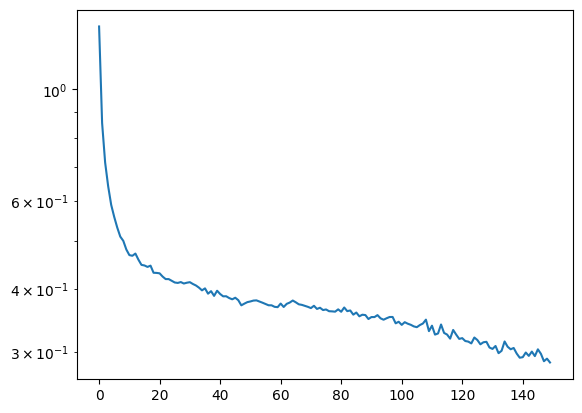

In [23]:
idx=0
plt.semilogy(results[idx]["train_losses"])

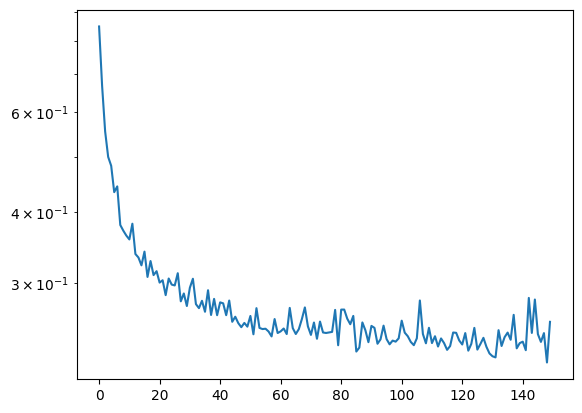

In [24]:
plt.semilogy(results[idx]["val_losses"])

In [25]:
ub_pred = results[idx]["ub_pred"]
lb_pred = results[idx]["lb_pred"]

In [26]:
lb_pred.shape, ub_pred.shape

((200, 51, 51), (200, 51, 51))

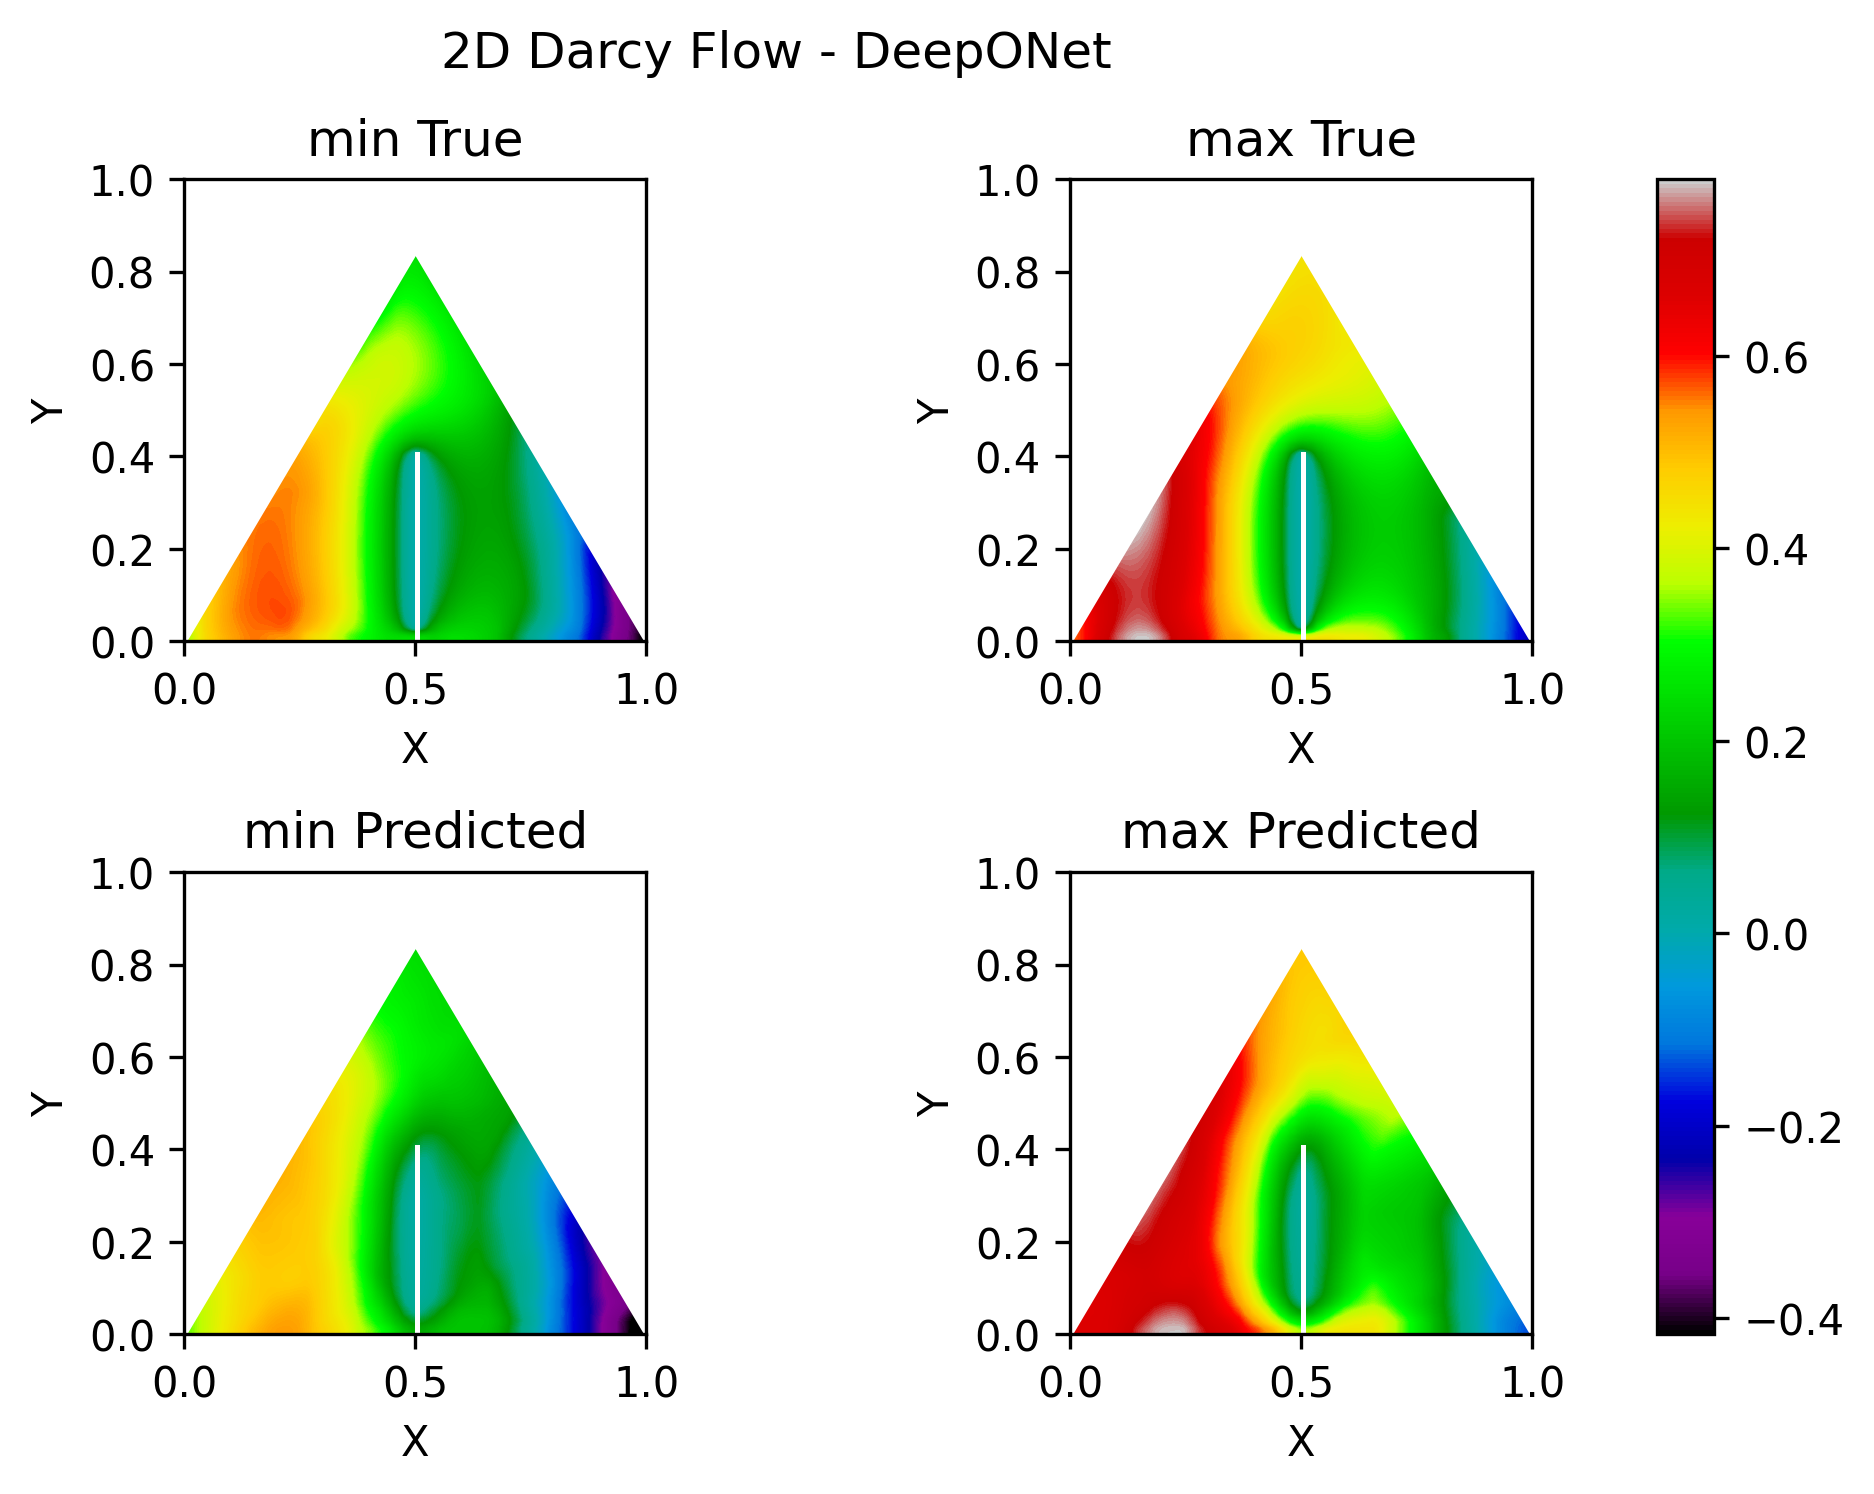

RMSE up = 0.1392
RMSE down = 0.1445


In [27]:
idx=0
ntest = 200

g_test = results[idx]["g_test"]
l_pred = lb_pred.reshape((ntest,51**2))
u_pred = ub_pred.reshape((ntest,51**2))

colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 5, 20)]

# --- Parameters ---
s_disp = 1
xmax, ymax = s_disp, s_disp - 8/51
value = 17
vmax = np.max(g_test[value, ...])
vmin = np.min(g_test[value, ...])

# --- Helper function for plotting ---
def plot_field(ax, field, title, vmin, vmax):
    im = ax.imshow(
        field.reshape((51, 51)),
        origin='lower',
        extent=[0, 1, 0, 1],
        interpolation='Gaussian',
        cmap='nipy_spectral',
        vmin=vmin, vmax=vmax
    )
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # White triangular masks
    xf = np.array([0., xmax/2])
    ax.fill_between(xf, xf*(ymax/(xmax/2)), ymax, color='white')
    xf = np.array([xmax/2, xmax])
    ax.fill_between(xf, (xf-xmax)*(ymax/((xmax/2)-xmax)), ymax, color='white')
    ax.fill_between([0, xmax], ymax, s_disp, color='white')

    # Rectangle mask
    ax.add_patch(Rectangle((0.5, 0), 0.01, 0.41, facecolor='white'))

    return im

# --- Figure ---
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(11, 5), dpi=300)
fig.suptitle('2D Darcy Flow - DeepONet')

fig.subplots_adjust(wspace=-0.2, hspace=0.5, right=0.88)

# True fields
im = plot_field(ax[0, 0], g_test[value, :, :, :, 0], "min True", vmin, vmax)
plot_field(ax[0, 1], g_test[value, :, :, :, 1], "max True", vmin, vmax)

# Predicted fields
plot_field(ax[1, 0], l_pred[value, :], "min Predicted", vmin, vmax)
plot_field(ax[1, 1], u_pred[value, :], "max Predicted", vmin, vmax)

# Shared colorbar
fig.colorbar(im, ax=ax.ravel().tolist())


plt.show()

# --- RMSE ---
rmse_up = np.sqrt(np.mean((g_test[...,0, 1] - ub_pred) ** 2))
print(f"RMSE up = {rmse_up:.4f}")

rmse_down = np.sqrt(np.mean((g_test[...,0, 0] - lb_pred) ** 2))
print(f"RMSE down = {rmse_down:.4f}")

In [28]:
g_test_int.shape

(200, 51, 51, 1, 2)